Sales Forecasting
#2. Univariate modeling
## 2-1. decomposition 

In [34]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.ar_model import AutoReg

In [3]:
data_path = "/content/drive/MyDrive/github_repo/time-series-study/data"

In [4]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [5]:
def plot_by_family(df:pd.DataFrame, store_id:int, categories:list=[], return_data:bool=False):
  if len(categories) == 0:
    df = df.loc[df.store_nbr==store_id, ][["date", "family", "sales"]]
  else:
    df = df.loc[(df.store_nbr==store_id) & (df.family.isin(categories)), ][["date", "family", "sales"]]
  df = pd.pivot(df, index=["date"], columns = "family", values = "sales").reset_index()

  fig = px.line(df, x="date", y=df.columns,
                hover_data={"date": "|%B %d, %Y"},
                title='sales time series')
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
  fig.show()
  return df if return_data else None

In [6]:
TARGET = "FROZEN FOODS" # ["LAWN AND GARDEN", "EGGS", "BEAUTY", "AUTOMOTIVE", "BOOKS", "FROZEN FOODS", "GROCERY I"]

In [7]:
train_df = plot_by_family(train, 44, [TARGET], True) 

## 1) traditional decomposition
* 연 단위로 peak 발생하여 period를 365로 설정하여 계산
* MA 기반 Trend 계산으로 인한 데이터 소실이 큼

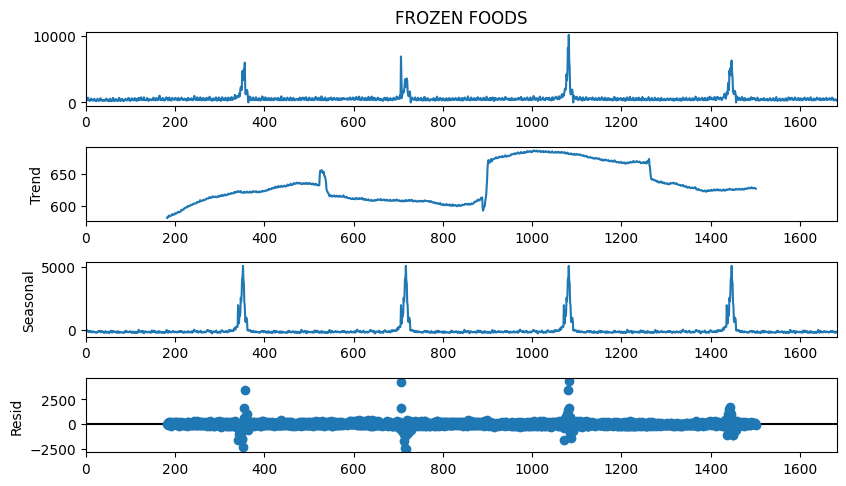

In [8]:
dec = seasonal_decompose(train_df[TARGET], model='additive', period=365)
fig = dec.plot()
fig.set_size_inches(9, 5)

##2) STL decomposition
*  데이터 소실 문제 없는 방법

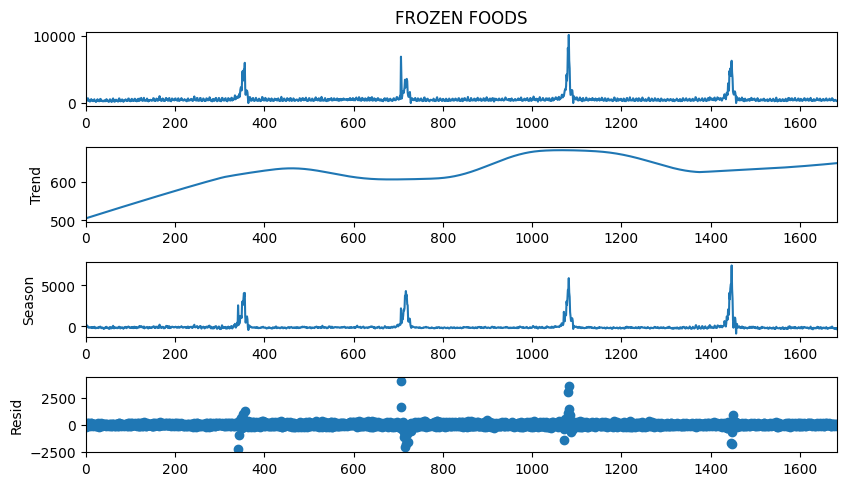

In [9]:
stl = STL(train_df[TARGET], seasonal=13, period=365)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(9, 5)

In [10]:
season_adj = train_df[TARGET]-res.seasonal

In [11]:
season_adj = pd.concat([train_df.date, season_adj], axis=1).rename(columns={0:"season_adj"})
fig = px.line(season_adj, x="date", y=season_adj.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='seasonal adjusted time series')
fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
fig.show()

## Decompose된 각 componenet를 AR 모형으로 예측
* testset에 ground truth가 없어 validation 데이터 만들어 테스트
* 참고사이트: https://www.pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/

In [37]:
valid_ratio = 0.7

In [29]:
def predict_components(components, component_nm:str, train_df:pd.DataFrame, val_ratio=0.7, lag=5):
  if component_nm == "seasonal": 
    component = components.seasonal
  elif component_nm == "trend": 
    component = components.trend
  elif component_nm == "resid": 
    component = components.resid
  else:
    raise ValueError('wrong component')

  train_series = component.iloc[:int(train_df.shape[0] * val_ratio)].tolist()
  test_series = component.iloc[int(train_df.shape[0] * val_ratio):]

  tmp_p = []
  for i in range(len(test_series)):
    model = AutoReg(train_series, lags=lag)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_series), end=len(train_series), dynamic=False)
    tmp_p.append(pred[0])
    train_series.append(test_series.iloc[i])
  
  preds = pd.Series(tmp_p, index=test_series.index, name=component_nm)
  test_score = np.sqrt(mean_squared_error(test_series, preds))
  print(f'Test for {component_nm} RMSE: {test_score}')
  
  plt.plot(test_series, label='TEST '+ component_nm)
  plt.plot(preds, label='PREDICTION '+ component_nm)
  plt.legend()
  plt.show()
  return preds

Test for seasonal RMSE: 282.5652423574726


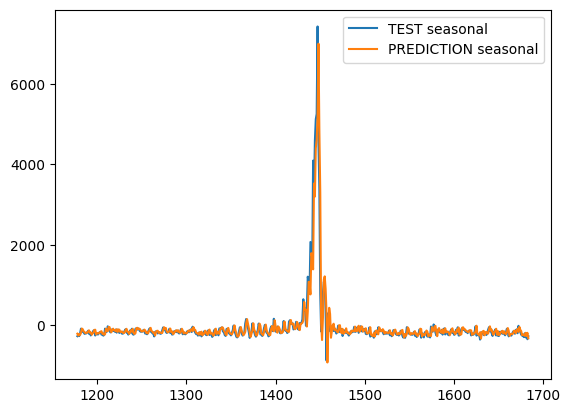

In [30]:
seasonal_pred = predict_components(res, "seasonal", train_df[TARGET])

Test for trend RMSE: 0.005252083043726852


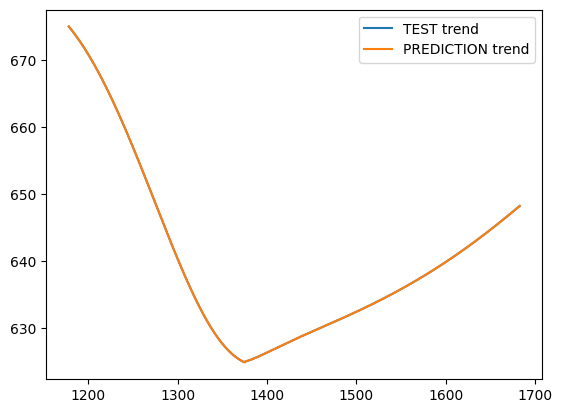

In [31]:
trend_pred = predict_components(res, "trend", train_df[TARGET])

Test for resid RMSE: 156.98201043700067


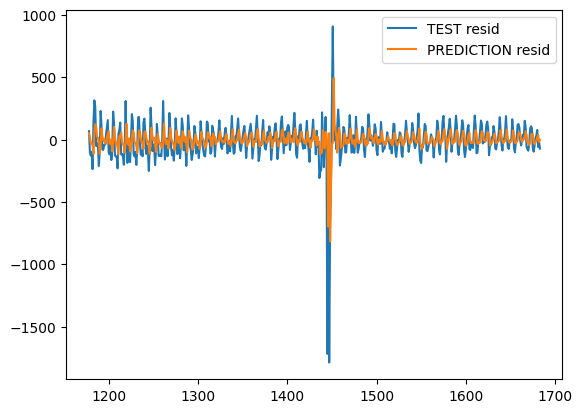

In [32]:
resid_pred = predict_components(res, "resid", train_df[TARGET])

* 예측한 각 component를 다시 결합한 후, validation time series와 성능평가

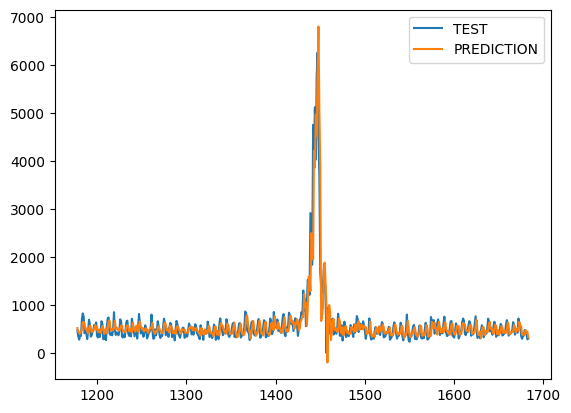

In [35]:
recomposed_preds = pd.concat([seasonal_pred, trend_pred, resid_pred],axis=1).sum(axis=1)
valids = train_df[TARGET].iloc[int(len(train_df[TARGET]) * valid_ratio):]
plt.plot(valids, label='TEST')
plt.plot(recomposed_preds, label='PREDICTION')
plt.legend()
plt.show()

In [36]:
print(f'MAE = {mean_absolute_error(valids, recomposed_preds)}')
print(f'MSE = {mean_squared_error(valids, recomposed_preds)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids, recomposed_preds))}')

MAE = 148.63337444676984
MSE = 81382.51946048091
RMSE = 285.27621607922543
